In [4]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [6]:
data_path = './data/'

train_ds = torchvision.datasets.FashionMNIST(data_path, download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)
test_ds = torchvision.datasets.FashionMNIST(data_path, download=True, train=False,
    transform=transforms.Compose([transforms.ToTensor()])
)

In [7]:
# DataLoader
# batch size 지정, data shuffle

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=100)    # 어떤 데이터를 불러올지 지정하고, batch_size 지정
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=100)

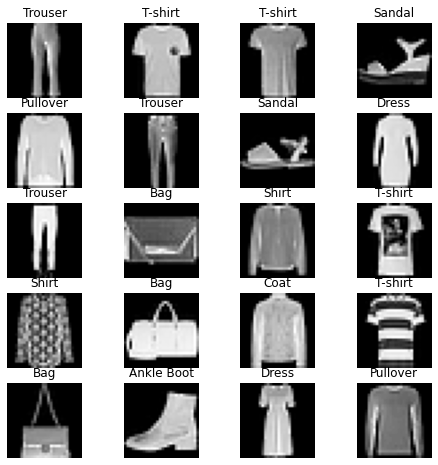

In [8]:
label = {0:'T-shirt', 1:'Trouser', 2:'Pullover', 3:'Dress', 4:'Coat', 5:'Sandal', 6:'Shirt', 7:'Sneaker', 8:'Bag', 9:'Ankle Boot'}

fig = plt.figure(figsize=(8,8))
cols = 4
rows = 5

for i in range(1, cols*rows +1):
    img_xy = np.random.randint(len(train_ds))
    img = train_ds[img_xy][0][0,:,:]
    fig.add_subplot(rows, cols, i)
    plt.title(label[train_ds[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')

plt.show()